In [1]:
import prop
import pandas as pd
import matplotlib.pyplot as plt
from modules import pump, regen, heater, turbine, condenser

#Таблица с потоками и блоками:
streams = pd.read_excel("streams.xlsx",index_col=0)
blocks  = pd.read_excel("blocks.xlsx" ,index_col=0)

#Параметры нагревающей среды:
gas  = 'REFPROP::N2[0.7757]&O2[0.1568]&CO2[0.0193]&H2O[0.04]&Ar[0.0082]' #Состав газа!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Tin  = 183.6                                                               #Температура газов на входе
Pgas = 0.1                                                                 #Давление газов
Ggas = 509                                                                 #Расход газов
Tout = 80                                                                  #Температура газов на выходе

#Параметры охлаждающей среды:
fluidcond  = "REFPROP::WATER" #Охлаждающая среда
Tfluidcond = 15               #Температура охл. среды
Pfluidcond = 0.5              #Давление охл. среды

#Параметры ОЦР:
fluid   = "REFPROP::R236ea"   #Рабочая среда цикла
Ppump   = 3.5                 #Давление на выходе из насоса
KPDpump = 0.8                 #КПД насоса
KPDturb = 0.9                 #КПД турбины
DTheat  = 20                  #Минимальный напор в нагревателе
DTcond  = 5                   #Минимальный напор в конденсаторе
Pcond   = prop.t_q(30,0,fluid)['P']               #Давление в конденсаторе

#Внесение входных данных в таблицу:
streams.loc["IN-HEAT", "T":"Q"] = [Tin,Pgas,prop.t_p(Tin,Pgas,gas)["H"],prop.t_p(Tin,Pgas,gas)["S"],Ggas,1]
streams.loc["IN-COND", "T":"Q"] = [Tfluidcond,Pfluidcond,prop.t_p(Tfluidcond,Pfluidcond,fluidcond)["H"],prop.t_p(Tfluidcond,Pfluidcond,fluidcond)["S"],1000,0]

#Начало расчёта - задание расхода на первой итерации:
G = Ggas*(prop.t_p(Tin,Pgas,gas)["H"]-prop.t_p(Tout,Pgas,gas)["H"])/(prop.t_p(Tin,Ppump,fluid)["H"]-prop.t_p(Tout,Ppump,fluid)["H"])

#Поток перед насосом:
streams.loc["COND-PUMP", "T":"Q"] = [prop.p_q(Pcond,0,fluid)["T"],Pcond,prop.p_q(Pcond,0,fluid)['H'],prop.p_q(Pcond,0,fluid)['S'],G,0]

#Итеративный расчет для сведения баланса:
for i in range(100):
    
    #Расчет цикла:
    pump.calc     ("COND-PUMP", "PUMP-REG",                          Ppump,  KPDpump,     fluid, streams, blocks)
    streams.loc["REG-HEAT", "T":"Q"] = streams.loc["PUMP-REG", "T":"Q"] #Игнор регенератора
    heater.calc   ("IN-HEAT",   "HEAT-OUT",  "REG-HEAT","HEAT-TURB", Tout,   DTheat, gas, fluid, streams, blocks)
    turbine.calc  ("HEAT-TURB", "TURB-REG",                          Pcond,  KPDturb,     fluid, streams, blocks)
    streams.loc["REG-COND", "T":"Q"] = streams.loc["TURB-REG", "T":"Q"] #Игнор регенератора
    condenser.calc("REG-COND",  "COND-PUMP", "IN-COND" ,"COND-OUT",  DTcond, fluidcond,   fluid, streams, blocks)
    
    #Тепловой баланс:
    Qbalance = blocks.loc['HEATER','Q']+blocks.loc['PUMP','N']-blocks.loc['CONDENSER','Q']-blocks.loc['TURBINE','N']
    print(i,round(Qbalance,5))
    
    #Выход из цикла при сведении баланса до требуемого уровня (в кВт):
    if abs(Qbalance) < 10**-2:
        print('+')
        break

0 -12.53376
1 6e-05
+


In [2]:
#КПД цикла:
KPD = 100*(blocks.loc['TURBINE','N']-blocks.loc['PUMP','N'])/blocks.loc['HEATER','Q']
print('КПД цикла: ', round(KPD,3),'%')

КПД цикла:  15.937 %


In [3]:
streams

,T,P,H,S,G,Q
IN-HEAT,183.600000,0.100000,527.439378,7.266439,509.000000,1.0
HEAT-OUT,80.000000,0.100000,419.639057,6.998847,509.000000,1.0
COND-PUMP,30.000000,0.244324,237.395788,1.129466,263.823415,0.0
PUMP-REG,31.711578,3.500000,240.271485,1.131354,263.823436,0.0
REG-HEAT,31.711578,3.500000,240.271485,1.131354,263.823436,0.0
HEAT-TURB,143.747040,3.500000,448.252886,1.691172,263.823415,1.0
TURB-REG,53.829351,0.244324,412.232091,1.703494,263.823415,1.0
REG-COND,53.829351,0.244324,412.232091,1.703494,263.823415,1.0
IN-COND,15.000000,0.500000,63.458441,0.224388,1000.000000,0.0
COND-OUT,26.027546,0.500000,109.584351,0.381478,1000.000000,0.0


In [4]:
blocks

,N,Q,COST
PUMP,758.676091,NaN,NaN
TURBINE,9503.129129,NaN,NaN
REGENERATOR,NaN,NaN,NaN
CONDENSER,NaN,46125.910502,NaN
HEATER,NaN,54870.363600,NaN


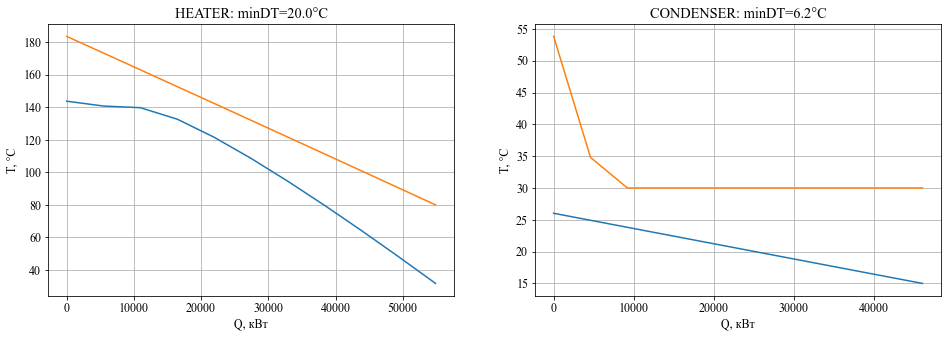

In [5]:
#Вывод T-Q:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
heater.TQ("IN-HEAT","HEAT-OUT","REG-HEAT","HEAT-TURB",gas,fluid,streams)
plt.subplot(1, 2, 2)
condenser.TQ("REG-COND","COND-PUMP","IN-COND","COND-OUT",fluidcond,fluid,streams)
plt.show()